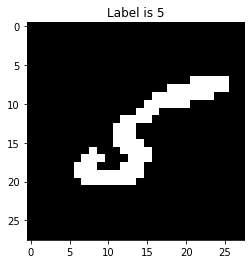

first mat dims torch.Size([784, 4000])
last mat dims torch.Size([500, 10])
connecting layer 784 4000 , this might take a while..
connected 50 nodes in the layer
connected 150 nodes in the layer
connected 250 nodes in the layer
connected 350 nodes in the layer
connected 450 nodes in the layer
connected 550 nodes in the layer
connected 650 nodes in the layer
connected 750 nodes in the layer
connecting layer 2000 2000 , this might take a while..
connected 50 nodes in the layer
connected 150 nodes in the layer
connected 250 nodes in the layer
connected 350 nodes in the layer
connected 450 nodes in the layer
connected 550 nodes in the layer
connected 650 nodes in the layer
connected 750 nodes in the layer
connected 850 nodes in the layer
connected 950 nodes in the layer
connected 1050 nodes in the layer
connected 1150 nodes in the layer
connected 1250 nodes in the layer
connected 1350 nodes in the layer
connected 1450 nodes in the layer
connected 1550 nodes in the layer
connected 1650 nodes

TypeError: iteration over a 0-d tensor

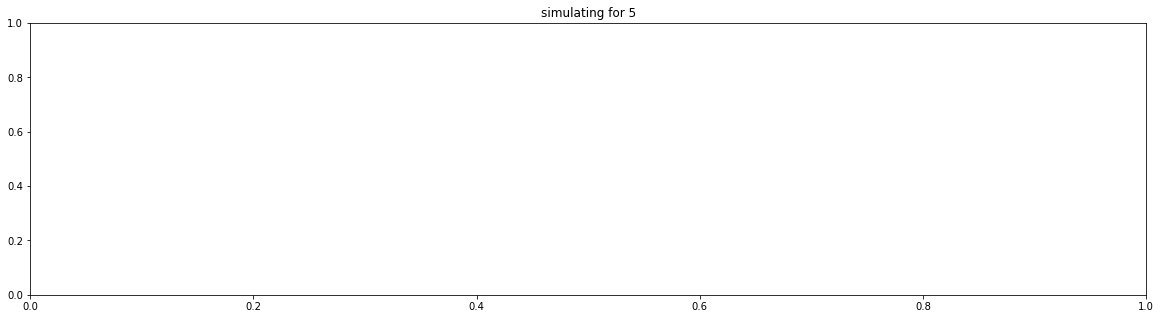

In [1]:
import torch
import modules.model2sim as sim

import torch
import torch.nn as nn

def Binarize(tensor, include_zero = True, minSig=3):
    if include_zero:
        P_std = 0.25
        up_lim = torch.min(0 + P_std*tensor.std(), torch.ones_like(tensor)*minSig)
        down_lim = torch.max(0 - P_std*tensor.std(), -1*torch.ones_like(tensor)*minSig)
        up_v = (tensor>up_lim).float()
        down_v = (tensor<down_lim).float().mul(-1)
        return (up_v + down_v)
    else:
        return tensor.sign()

class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(784, 2000, bias=False)
        self.bn1 = nn.BatchNorm1d(2000)
        self.htanh1 = nn.Hardtanh()
        self.fc2 = BinarizeLinear(2000, 1000, bias=False)
        self.bn2 = nn.BatchNorm1d(1000)
        self.htanh2 = nn.Hardtanh()
        self.drop=nn.Dropout(0.5)
        self.fc3 = BinarizeLinear(1000, 500, bias=False)
        self.bn3 = nn.BatchNorm1d(500)
        self.htanh3 = nn.Hardtanh()
        self.fc4 = BinarizeLinear(500, 250, bias=False)
        self.bn4 = nn.BatchNorm1d(250)
        self.htanh4 = nn.Hardtanh()
        self.fc5 = BinarizeLinear(250, 10, bias=False)
        self.logsoftmax=nn.LogSoftmax()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.drop(x)
        x = self.htanh2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.htanh4(x)
        x = self.fc5(x)
        x = self.logsoftmax(x)
        return x

"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.infl_ratio=3
        self.fc1 = BinarizeLinear(784, 2048*self.infl_ratio)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(2048*self.infl_ratio)
        self.fc2 = BinarizeLinear(2048*self.infl_ratio, 2048*self.infl_ratio)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(2048*self.infl_ratio)
        self.fc3 = BinarizeLinear(2048*self.infl_ratio, 2048*self.infl_ratio)
        self.htanh3 = nn.Hardtanh()
        self.bn3 = nn.BatchNorm1d(2048*self.infl_ratio)
        self.fc4 = nn.Linear(2048*self.infl_ratio, 10)
        self.logsoftmax=nn.LogSoftmax()
        self.drop=nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.htanh2(x)
        x = self.fc3(x)
        x = self.drop(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        x = self.fc4(x)
        return self.logsoftmax(x)"""


model = Net()
model.load_state_dict(torch.load("trained_models/test1.pt",map_location=torch.device('cpu')))
model.eval()
res, model_act = sim.testMNIST(model)

In [ ]:
parse, sum = sim.testSim(res, model_act,4,1,4)
pprint(parse)
print("sum:",sum)